In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data = np.load("../../Data/development.npy")
data_csv = pd.read_csv("../../Data/metadata/development.csv")
idx_to_feature_name = pd.read_csv("../../Data/metadata/idx_to_feature_name.csv")

In [3]:
labels = data_csv['word']
y = {}
labels_new = []

i = 0
for label in np.unique(labels).tolist():
    if label == 'other':
        continue
    else:
        y[label] = i
        i += 1
for label in labels:
    if label == 'other':
        continue
    else:
        labels_new.append(y[label])

In [5]:
data_no_other = data[:40834, :, :]

In [8]:
y

{'Alarm': 0,
 'Brötchen': 1,
 'Fernseher': 2,
 'Haus': 3,
 'Heizung': 4,
 'Leitung': 5,
 'Licht': 6,
 'Lüftung': 7,
 'Ofen': 8,
 'Radio': 9,
 'Schraube': 10,
 'Spiegel': 11,
 'Staubsauger': 12,
 'an': 13,
 'aus': 14,
 'kann': 15,
 'nicht': 16,
 'offen': 17,
 'warm': 18,
 'wunderbar': 19}

In [ ]:
np.argsort(data_no_other, axis=2, order='ascending')
print

In [6]:
#data_new = np.concatenate((data[:, :11, :], data[:, 171:, :]), axis=1)
#data_test = np.concatenate((data[:4, :11, :], data[:4, 76:, :]), axis=1)
#data_train = np.concatenate((data_no_other[:36236, :22, :], data_no_other[:36236, 87:, :]), axis=1) # data[samples, features, ...]
#data_valid = np.concatenate((data_no_other[36236:, :22, :], data_no_other[36236:, 87:, :]), axis=1)
#data_train = data[:36236, :, :]
#data_valid = data[36236:, :, :] 32667

data_train = np.concatenate((data_no_other[:32667, :22, :], data_no_other[:32667, 87:, :]), axis=1) # data[samples, features, ...]
data_valid = np.concatenate((data_no_other[32667:, :22, :], data_no_other[32667:, 87:, :]), axis=1)
print(data_train.shape, data_valid.shape)

(32667, 110, 44) (8167, 110, 44)


In [10]:
# 15 Features, Everything up to flux_0, and from power_0 - no melspect and no mfcc
data_train = np.concatenate((data_no_other[:32667, :11, :], data_no_other[:32667, 171:, :]), axis=1)
data_valid = np.concatenate((data_no_other[32667:, :11, :], data_no_other[32667:, 171:, :]), axis=1)

labels_train = labels_new[:32667]
labels_valid = labels_new[32667:]

print(data_train.shape, data_valid.shape)

(32667, 15, 44) (8167, 15, 44)


In [5]:
# 110 features, up to 'melspect\_10' and from 'mfcc\_11' 
data_train = np.concatenate((data_no_other[:32667, :22, :], data_no_other[:32667, 87:, :]), axis=1) # data[samples, features, ...]
data_valid = np.concatenate((data_no_other[32667:, :22, :], data_no_other[32667:, 87:, :]), axis=1)

labels_train = labels_new[:32667]
labels_valid = labels_new[32667:]

print(data_train.shape, data_valid.shape)

(32667, 110, 44) (8167, 110, 44)


In [31]:
data_csv.shape

(45296, 4)

In [19]:
data_csv_no_other = data_csv[:40834]

speakers = np.unique(data_csv_no_other['speaker_id'])
speakers_train = speakers[:137] 
speakers_valid = speakers[137:]

train_indices = np.where(data_csv_no_other['speaker_id'].isin(speakers_train))[0].tolist()
valid_indices = np.where(data_csv_no_other['speaker_id'].isin(speakers_valid))[0].tolist()

data_train = data_no_other[train_indices]
data_valid = data_no_other[valid_indices]

labels_train = data_csv_no_other['word'][train_indices].tolist()
labels_valid = data_csv_no_other['word'][valid_indices].tolist()

labels = data_csv_no_other['word']
y = {}
i = 0
for label in np.unique(data_csv_no_other['word']).tolist():
    y[label] = i
    i += 1
labels_train_num = []
labels_valid_num = []

for label in labels_train:
    labels_train_num.append(y[label])
for label in labels_valid:
    labels_valid_num.append(y[label])
    

In [20]:
print(f"Dataset: Train: {data_train.shape}, Valid: {data_valid.shape}")
print(f"Labels: Train: {len(labels_train_num)}, Valid: {len(labels_valid_num)}")

Dataset: Train: (32642, 175, 44), Valid: (8192, 175, 44)
Labels: Train: 32642, Valid: 8192


In [15]:
# All Features - We use this, ignore others
data_train = data_no_other[:32667, :, :]
data_valid = data_no_other[32667:, :, :]

labels_train = labels_new[:32667]
labels_valid = labels_new[32667:]

print(data_train.shape, data_valid.shape)

(32667, 175, 44) (8167, 175, 44)


In [21]:
X_tensor_train = torch.tensor(data_train, dtype=torch.float32)
y_tensor_train = torch.tensor(labels_train_num, dtype=torch.long)
X_tensor_valid = torch.tensor(data_valid, dtype=torch.float32)
y_tensor_valid = torch.tensor(labels_valid_num, dtype=torch.long)

In [22]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [23]:
from model_architectures import EnhancedAudioCNN

In [24]:
model = EnhancedAudioCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

dataset_train = CustomDataset(X_tensor_train, y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, drop_last=True)

dataset_valid = CustomDataset(X_tensor_valid, y_tensor_valid)
dataloader_valid = DataLoader(dataset_valid, batch_size=64, shuffle=False, drop_last=True)

use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")
model.to(device)

EnhancedAudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1280, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=20, bias=True)
)

In [25]:
# Example training loop
num_epochs = 50
#total_iterations = num_epochs * (len(dataloader_train) + len(dataloader_valid))
#progress_bar = tqdm(total=total_iterations, desc='Training and Evaluation')

losses_train = []
losses_valid = []

for epoch in range(num_epochs):
    model.train()
    for features, labels in dataloader_train:
        optimizer.zero_grad()
        features = features.unsqueeze(1)
        inputs = features.to(device)
        targets = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    losses_train.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for features, labels in dataloader_valid:
            inputs = features.to(device)
            inputs = inputs.unsqueeze(1)
            targets = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        losses_valid.append(loss.item())
    if (losses_train[-1] + losses_valid[-1])/2 < 0.1:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'model_epoch_{epoch}.pth')
    #progress_bar.update(2)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training loss: {losses_train[-1]}, Validation loss: {losses_valid[-1]}')

Epoch 1/50, Training loss: 1.293847680091858, Validation loss: 1.1366536617279053
Epoch 2/50, Training loss: 0.7892315983772278, Validation loss: 0.8589993715286255
Epoch 3/50, Training loss: 1.079101800918579, Validation loss: 0.8948773741722107
Epoch 4/50, Training loss: 0.3205069601535797, Validation loss: 0.513160228729248
Epoch 5/50, Training loss: 0.24344690144062042, Validation loss: 0.404680073261261
Epoch 6/50, Training loss: 0.33661848306655884, Validation loss: 0.39317816495895386
Epoch 7/50, Training loss: 0.23953884840011597, Validation loss: 0.41994333267211914
Epoch 8/50, Training loss: 0.356278657913208, Validation loss: 0.47362416982650757
Epoch 9/50, Training loss: 0.24688220024108887, Validation loss: 0.5389707088470459
Epoch 10/50, Training loss: 0.2163635492324829, Validation loss: 0.4154473543167114
Epoch 11/50, Training loss: 0.3078569173812866, Validation loss: 0.4374382197856903
Epoch 12/50, Training loss: 0.2954150438308716, Validation loss: 0.2228084653615951

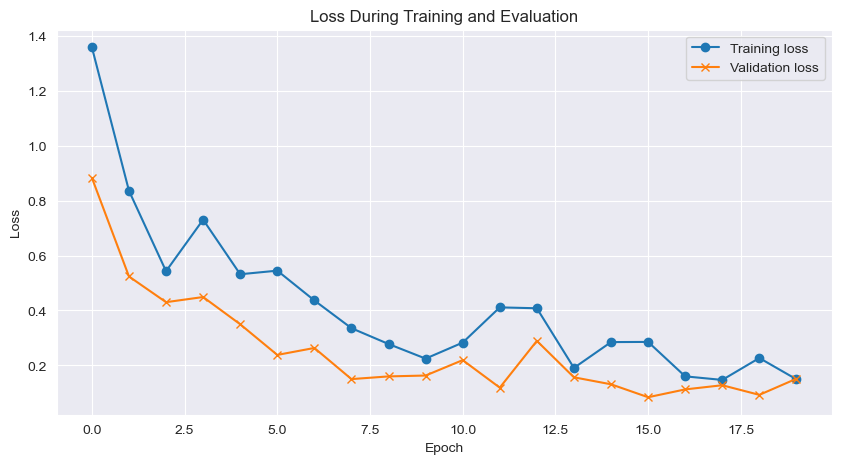

In [62]:
import matplotlib.pyplot as plt

# Assuming 'losses' is a list of float numbers representing the loss values
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(losses_train, label='Training loss', marker='o')
plt.plot(losses_valid, label='Validation loss', marker='x')  # Plot the losses with line and markers
plt.title('Loss During Training and Evaluation')  # Give the plot a title
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.grid(True)  # Enable grid for easier readability
plt.legend()
plt.show()  # Display the plot

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import torch
from sklearn.svm import SVC



X_train = data_train.reshape(data_train.shape[0], -1)
X_valid = data_valid.reshape(data_valid.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Define different SVM models
svm_linear = SVC(kernel='linear')
svm_poly = SVC(kernel='poly', degree=3)  # Degree can be tuned
svm_rbf = SVC(kernel='rbf')
svm_sigmoid = SVC(kernel='sigmoid')

# Train and evaluate each model
# for svm_model, name in zip([svm_linear, svm_poly, svm_rbf, svm_sigmoid], ['Linear', 'Polynomial', 'RBF', 'Sigmoid']):
for svm_model, name in zip([svm_rbf], ['RBF']):
    svm_model.fit(X_train, labels_train)
    y_pred = svm_model.predict(X_valid)
    accuracy = accuracy_score(labels_valid, y_pred)
    report = classification_report(labels_valid, y_pred)
    
    print(f"{name} SVM Accuracy: {accuracy}")
    print(f"{name} SVM Classification Report:")
    print(report)
    print("\n" + "="*60 + "\n")

KeyboardInterrupt: 

In [26]:
melspect_indices = list(range(12, 76))
licht_snippet = data[14, melspect_indices, :]


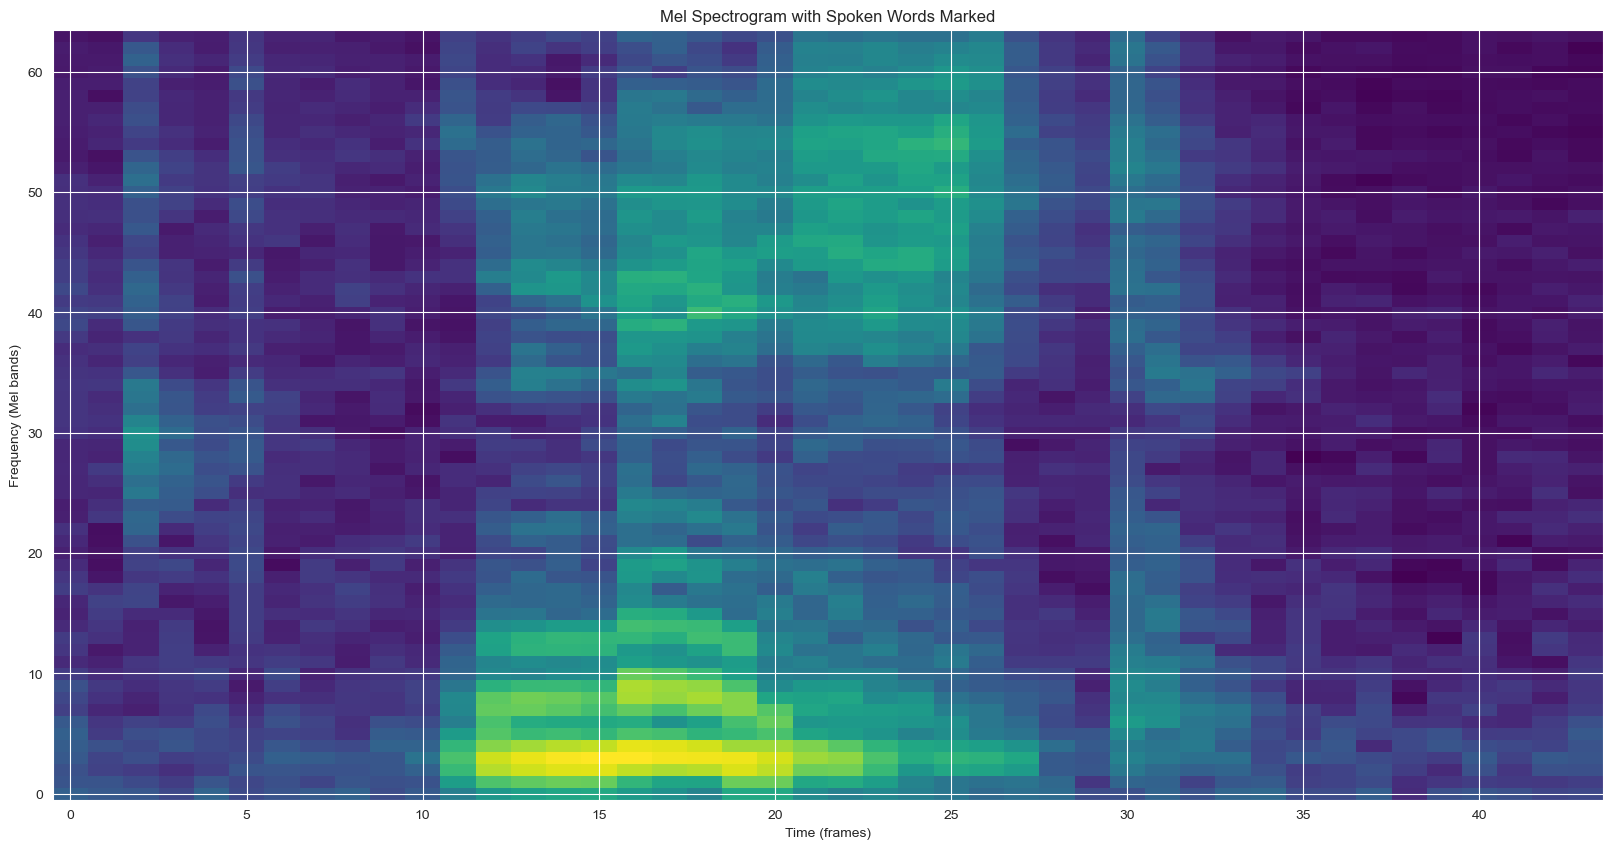

In [27]:
plt.figure(figsize=(20, 10))
plt.imshow(licht_snippet, aspect='auto', origin='lower', cmap='viridis')
plt.title('Mel Spectrogram with Spoken Words Marked')
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Mel bands)')
plt.show()